# Quantum ODE LSTM for Stock Price Prediction

This notebook demonstrates the implementation of a Quantum ODE LSTM model for predicting stock prices.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch import nn
import time
from datetime import datetime
import yfinance as yf
from sklearn.metrics import mean_squared_error

# Import custom modules
from QODE import SequenceDataset, QODEShallowRegressionLSTM

# Set random seed for reproducibility
torch.manual_seed(101)

## Data Loading and Preparation

In [2]:
# Download data or load from file
# Uncomment below to download data from Yahoo Finance
# data = yf.download("AAPL", start="2022-01-01", end="2023-01-01")
# data.to_csv('AAPL_2022-01-01_2023-01-01.csv')

# Load data from file
df = pd.read_csv('./AAPL_2022-01-01_2023-01-01.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,177.830002,182.880005,177.710007,182.009995,179.724533,104487900
1,2022-01-04,182.630005,182.940002,179.119995,179.699997,177.443542,99310400
2,2022-01-05,179.610001,180.169998,174.639999,174.919998,172.723587,94537600
3,2022-01-06,172.699997,175.300003,171.639999,172.000000,169.840256,96904000
4,2022-01-07,172.889999,174.139999,171.029999,172.169998,170.008102,86709100


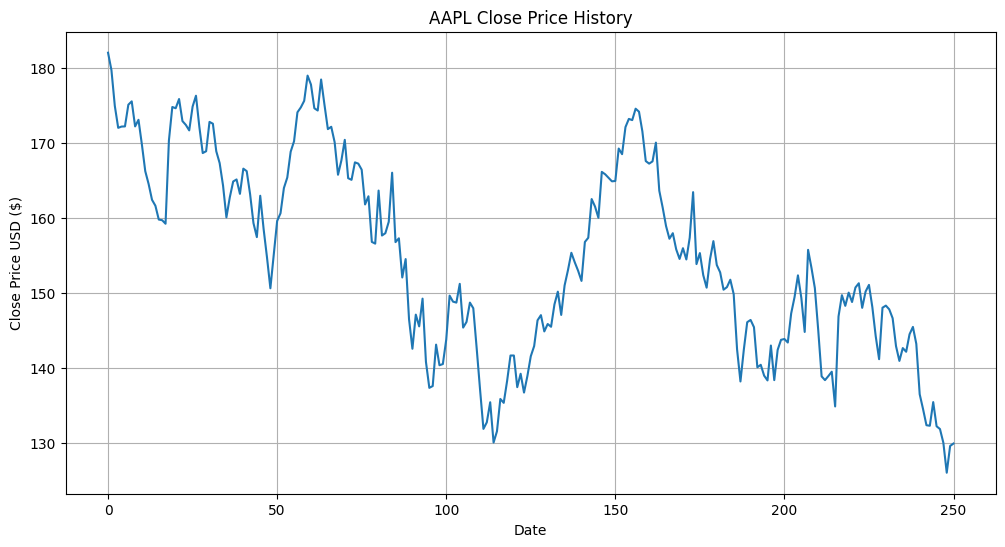

In [3]:
# Prepare data for model
columns = ["Close"]
data = df.filter(columns)
dataset = data.values

# Plot the original stock price data
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title('AAPL Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.grid(True)
plt.show()

In [4]:
# Splitting the data into train and test
size = int(len(df) * 0.7)
df_train = dataset[:size].copy()
df_test = dataset[size:].copy()

# Select the features
df_train = pd.DataFrame(df_train, columns=columns)
df_test = pd.DataFrame(df_test, columns=columns)

features = df_train.columns
target = 'Close'

print(f"Training data: {df_train.shape}")
print(f"Testing data: {df_test.shape}")

Training data: (175, 1)
Testing data: (76, 1)


In [5]:
# Normalization function
def normalize(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

# Normalizing the data
df_train_norm, min_train, max_train = normalize(df_train)
df_test_norm, _, _ = normalize(df_test, min_train, max_train)

print("Normalization range:")
print(f"Min: {min_train}")
print(f"Max: {max_train}")

Normalization range:
Min: Close    130.059998
dtype: float64
Max: Close    182.009995
dtype: float64


## Prepare DataLoaders

In [6]:
# Set hyperparameters
batch_size = 1
sequence_length = 3

# Create datasets
train_dataset = SequenceDataset(
    df_train_norm,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test_norm,
    target=target,
    features=features,
    sequence_length=sequence_length
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check data shape
X, y = next(iter(train_loader))
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 1])
Target shape: torch.Size([1])


## Define Training and Testing Functions

In [7]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss:.6f}")
    return avg_loss

def test_model(data_loader, model, loss_function): 
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss:.6f}")
    return avg_loss

def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

## Initialize QODE LSTM Model

In [8]:
# Set hyperparameters
learning_rate = 0.01
num_hidden_units = 7
n_qubits = 4  # Number of qubits for quantum circuits
n_qlayers = 1  # Number of quantum layers

# Initialize the QODE LSTM model
model = QODEShallowRegressionLSTM(
    num_sensors=len(features),
    hidden_units=num_hidden_units,
    n_qubits=n_qubits,
    n_qlayers=n_qlayers
)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Count number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 79


## Train the Model

In [ ]:
# Training settings
num_epochs = 30  # Reduced for quantum simulation

qode_loss_train = []
qode_loss_test = []

print("Starting training...")
start_time = time.time()

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch+1}/{num_epochs}")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    qode_loss_train.append(train_loss)
    qode_loss_test.append(test_loss)
    
    # Print elapsed time every 5 epochs
    if (ix_epoch + 1) % 5 == 0:
        elapsed_time = time.time() - start_time
        print(f"Time elapsed: {elapsed_time:.2f} seconds")
print(f"Training completed in {time.time() - start_time:.2f} seconds")

: 

## Evaluate the Model

In [ ]:
# Create evaluation loaders (no shuffling)
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Generate predictions
ystar_col = "QODE LSTM Forecast"
df_train_norm[ystar_col] = predict(train_eval_loader, model).numpy()
df_test_norm[ystar_col] = predict(test_eval_loader, model).numpy()

# Denormalize the results
for col in [target, ystar_col]:
    df_train[ystar_col] = df_train_norm[col] * (max_train - min_train) + min_train
    df_test[ystar_col] = df_test_norm[col] * (max_train - min_train) + min_train

In [ ]:
# Plot the results
plt.figure(figsize=(14, 7))

# Training set predictions
plt.subplot(1, 2, 1)
plt.plot(df_train[target], label='Actual (Train)')
plt.plot(df_train[ystar_col], label='Predicted (Train)')
plt.title('QODE LSTM: Training Set Predictions')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

# Test set predictions
plt.subplot(1, 2, 2)
plt.plot(df_test[target], label='Actual (Test)')
plt.plot(df_test[ystar_col], label='Predicted (Test)')
plt.title('QODE LSTM: Test Set Predictions')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(qode_loss_train, label='Training Loss')
plt.plot(qode_loss_test, label='Testing Loss')
plt.title('QODE LSTM: Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Save the loss data
pd.DataFrame({'train_loss': qode_loss_train, 'test_loss': qode_loss_test}).to_csv('QODE_LSTM_loss.csv', index=False)

## Performance Metrics

In [ ]:
# Calculate the RMSE for the train and test data
train_rmse = math.sqrt(mean_squared_error(df_train[target], df_train[ystar_col]))
test_rmse = math.sqrt(mean_squared_error(df_test[target], df_test[ystar_col]))
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Calculate the accuracy of the model (percentage of predictions within 10% of actual value)
def accuracy(y, y_star):
    return np.mean(np.abs(y - y_star) / y < 0.1) * 100

train_accuracy = accuracy(df_train[target], df_train[ystar_col])
test_accuracy = accuracy(df_test[target], df_test[ystar_col])
print(f"Train accuracy (predictions within 10% of actual): {train_accuracy:.2f}%")
print(f"Test accuracy (predictions within 10% of actual): {test_accuracy:.2f}%")

## Save the Model

In [ ]:
# Save the model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(model.state_dict(), f"qode_lstm_model_{timestamp}.pth")
print(f"Model saved as qode_lstm_model_{timestamp}.pth")

## Compare with Classical LSTM (Optional)

In [ ]:
# If you have results from a classical LSTM, you can compare them here
try:
    classical_loss = pd.read_csv('LSTM_loss.csv')
    
    plt.figure(figsize=(10, 6))
    plt.plot(classical_loss.iloc[:, 0], label='Classical LSTM')
    plt.plot(qode_loss_train, label='QODE LSTM')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()
except FileNotFoundError:
    print("Classical LSTM results not found. Run the classical LSTM model first for comparison.")